In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import scale
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from tensorflow.keras import Model ,models, layers, optimizers, utils, losses
import tensorflow as tf

from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

import warnings
warnings.filterwarnings('ignore')

# 상관계수
import scipy.stats as stats

# 분산분석
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# 사후분석
from statsmodels.sandbox.stats.multicomp import MultiComparison

%matplotlib inline
plt.rcParams['figure.figsize'] = [25,12]
pd.options.display.float_format = '{:.3f}'.format

* INSP : inspection number 검사 번호

* 66개의 평균 or 분산 or 최대, 최솟값

In [3]:
sqci=pd.read_csv('DC90_29900B_time_raw.csv')
# 소요시간을 알고싶음
sqci['DURATION_TIME'] = sqci['END_TIME'] - sqci['START_TIME']

In [4]:
sqci2 = sqci[['INSP_DTL_SEQ', 'INSP_DTL_CODE', 'VALUE', 'PROD_SN', 'START_TIME', 'END_TIME', 'PASS_YN', 'DURATION_TIME']]
sqci2['PASS_YN'] = sqci2['PASS_YN'].map({'Y':1,
                                         'N':0})   # 1이면 성공, 0이면 실패
sqci2['INSP_DTL_CODE'] = sqci2['INSP_DTL_CODE'].map({'AD01':1,
                                                    'AD02':2})

In [4]:
sqci2.head()

,INSP_DTL_SEQ,INSP_DTL_CODE,VALUE,PROD_SN,START_TIME,END_TIME,PASS_YN,DURATION_TIME
0,0,1,0.000,39DC9029900B620ARAN0001,20211022115325,20211022115430,1,105
1,1,1,0.000,39DC9029900B620ARAN0001,20211022115325,20211022115430,1,105
2,2,1,7.000,39DC9029900B620ARAN0001,20211022115325,20211022115430,1,105
3,3,1,36.000,39DC9029900B620ARAN0001,20211022115325,20211022115430,1,105
4,4,1,36.000,39DC9029900B620ARAN0001,20211022115325,20211022115430,1,105


### 각 SN당 SEQ의 평균, 최대, 최솟값

In [5]:
len(sqci2['PROD_SN'].unique())

5233

In [19]:
sqci_group_mean = sqci2.groupby(['PROD_SN', 'PASS_YN']).mean() # sn당 value의 평균
sqci_group_mean.reset_index(inplace = True)
sqci_group_mean = sqci_group_mean[['PROD_SN', 'PASS_YN', 'VALUE', 'DURATION_TIME']]

sqci_group_max = sqci2.groupby(['PROD_SN', 'PASS_YN']).max() # sn당 value의 최댓값
sqci_group_max.reset_index(inplace = True)
sqci_group_max = sqci_group_max[['PROD_SN', 'PASS_YN', 'VALUE', 'DURATION_TIME']]

sqci_group_min = sqci2.groupby(['PROD_SN', 'PASS_YN']).min() # sn당 value의 최솟값
sqci_group_min.reset_index(inplace = True)
sqci_group_min = sqci_group_min[['PROD_SN', 'PASS_YN', 'VALUE', 'DURATION_TIME']]

In [20]:
sqci_group_mean_y = sqci_group_mean[sqci_group_mean['PASS_YN'] == 1]
sqci_group_mean_n = sqci_group_mean[sqci_group_mean['PASS_YN'] == 0]

sqci_group_max_y = sqci_group_max[sqci_group_max['PASS_YN'] == 1]
sqci_group_max_n = sqci_group_max[sqci_group_max['PASS_YN'] == 0]

sqci_group_min_y = sqci_group_min[sqci_group_min['PASS_YN'] == 1]
sqci_group_min_n = sqci_group_min[sqci_group_min['PASS_YN'] == 0]

In [8]:
sqci_group_mean[sqci_group_mean['PROD_SN'] == '39DC9029900B620ARAX0013']

,PROD_SN,PASS_YN,VALUE,DURATION_TIME
246,39DC9029900B620ARAX0013,0,169.161,105.000
247,39DC9029900B620ARAX0013,1,238.005,106.000


In [9]:
sqci_group_max[sqci_group_max['PROD_SN'] == '39DC9029900B620ARAX0013']

,PROD_SN,PASS_YN,VALUE,DURATION_TIME
246,39DC9029900B620ARAX0013,0,446.000,105
247,39DC9029900B620ARAX0013,1,636.000,106


## mean, max, min 분포 그래프

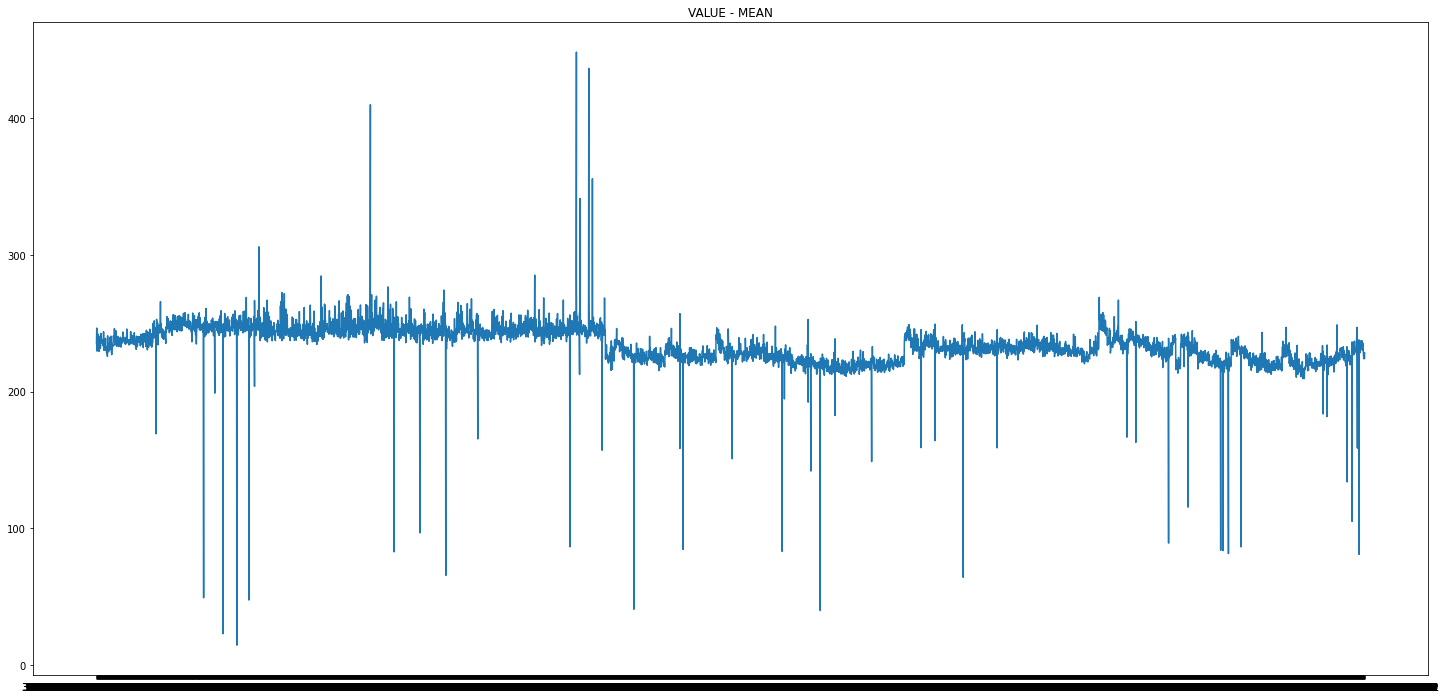

In [10]:
plt.plot(sqci_group_mean['PROD_SN'], sqci_group_mean['VALUE'])
plt.title('VALUE - MEAN')
#plt.legend('PASS_YN')
plt.show()

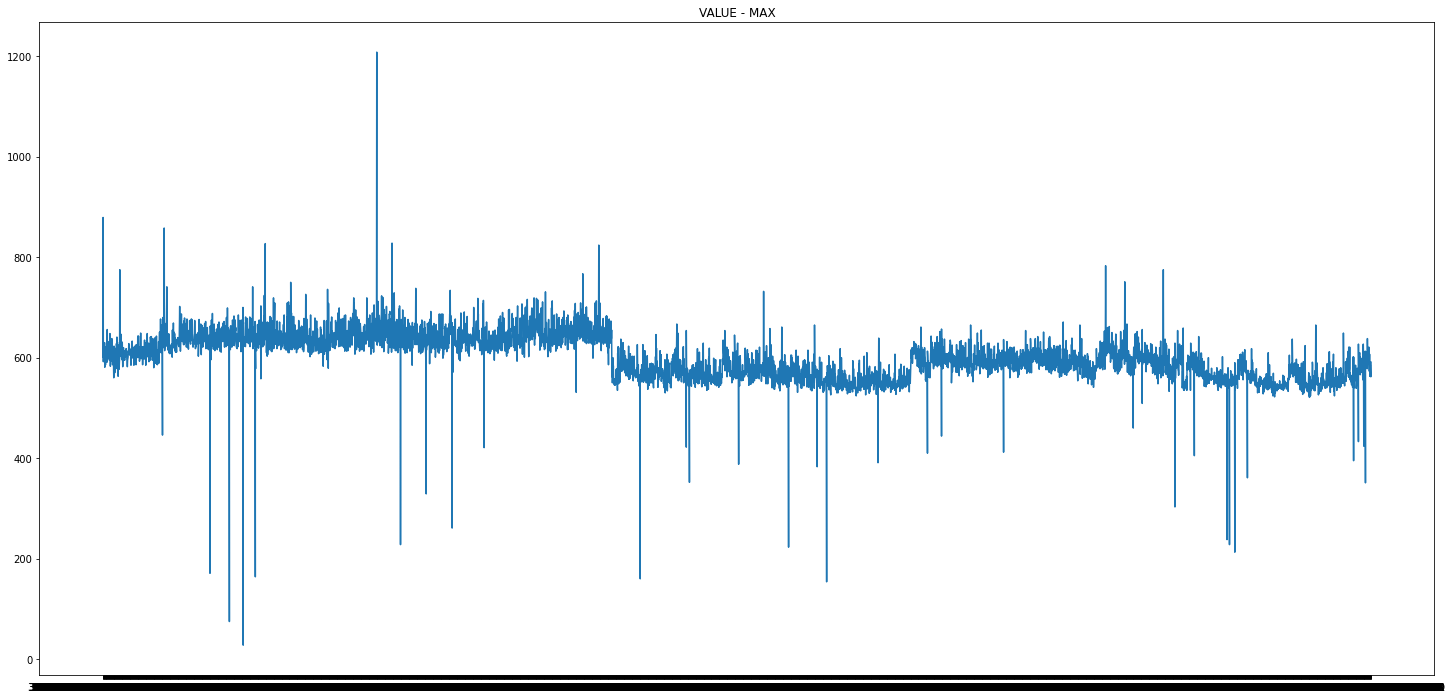

In [11]:
plt.plot(sqci_group_max['PROD_SN'], sqci_group_max['VALUE'])
plt.title('VALUE - MAX')
#plt.legend('PASS_YN')
plt.show()

In [21]:
x1 = sqci_group_mean_y['PROD_SN'] 
y1 = sqci_group_mean_y['VALUE']

x2 = sqci_group_mean_n['PROD_SN']
y2 = sqci_group_mean_n['VALUE']

x3 = sqci_group_max_y['PROD_SN'] 
y3 = sqci_group_max_y['VALUE']

x4 = sqci_group_max_n['PROD_SN']
y4 = sqci_group_max_n['VALUE']

x5 = sqci_group_min_y['PROD_SN'] 
y5 = sqci_group_min_y['VALUE']

x6 = sqci_group_min_n['PROD_SN']
y6 = sqci_group_min_n['VALUE']

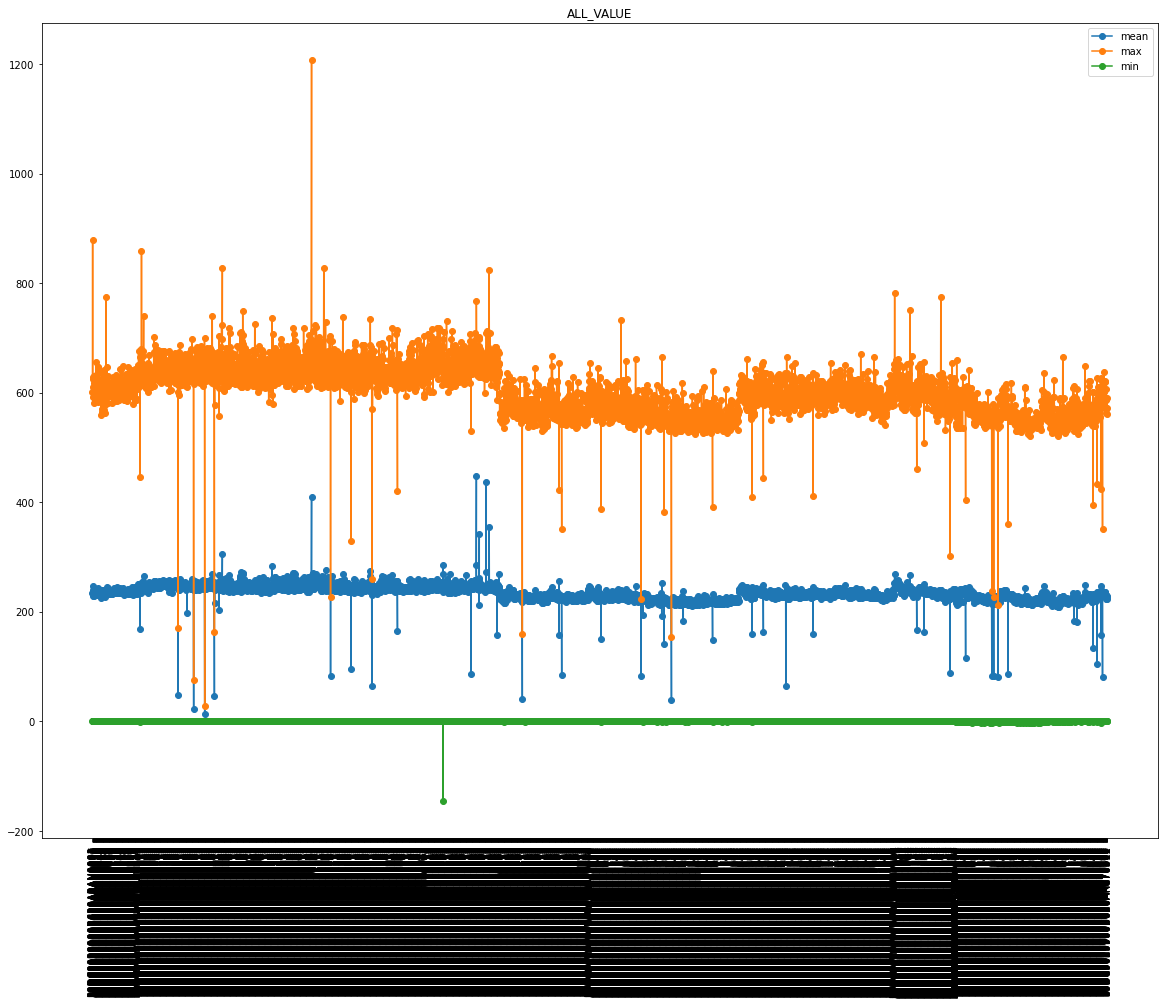

In [22]:
# ALL
fig = plt.figure(figsize=(20,15)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 색상 설정
ax = fig.add_subplot() ## 그림 뼈대(프레임) 생성
 
ax.plot(sqci_group_mean['PROD_SN'], sqci_group_mean['VALUE'], marker='o',label='mean') ## 선그래프 생성
ax.plot(sqci_group_max['PROD_SN'], sqci_group_max['VALUE'], marker='o',label='max') 
ax.plot(sqci_group_min['PROD_SN'], sqci_group_min['VALUE'], marker='o',label='min') 

ax.legend()
plt.title('ALL_VALUE')
plt.xticks(rotation = 90)
plt.show()

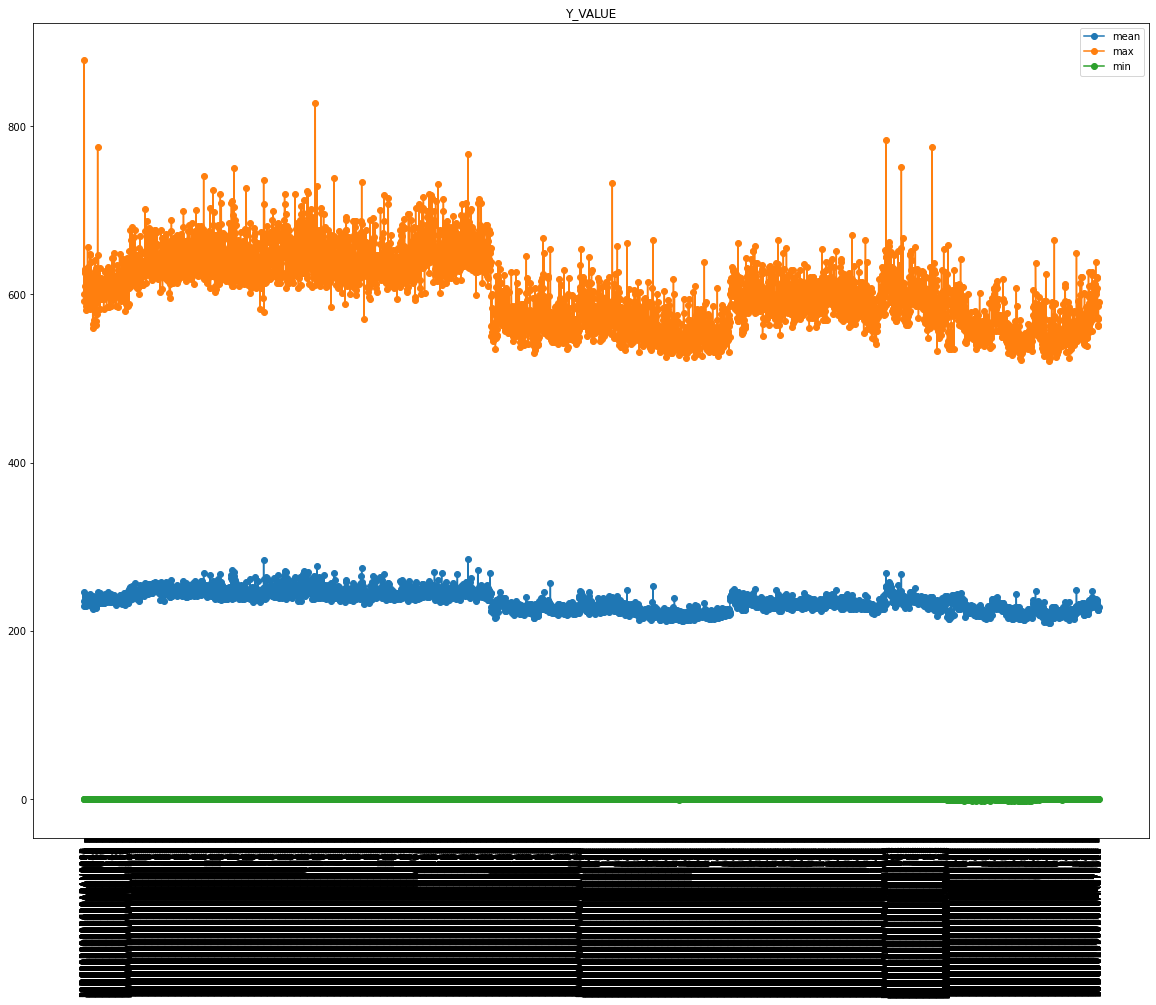

In [23]:
# Y

fig = plt.figure(figsize=(20,15)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 색상 설정
ax = fig.add_subplot() ## 그림 뼈대(프레임) 생성
 
ax.plot(x1, y1, marker='o',label='mean') ## 선그래프 생성
ax.plot(x3, y3, marker='o',label='max') 
ax.plot(x5, y5, marker='o',label='min') 

ax.legend()
plt.title('Y_VALUE')
plt.xticks(rotation = 90)
plt.show()

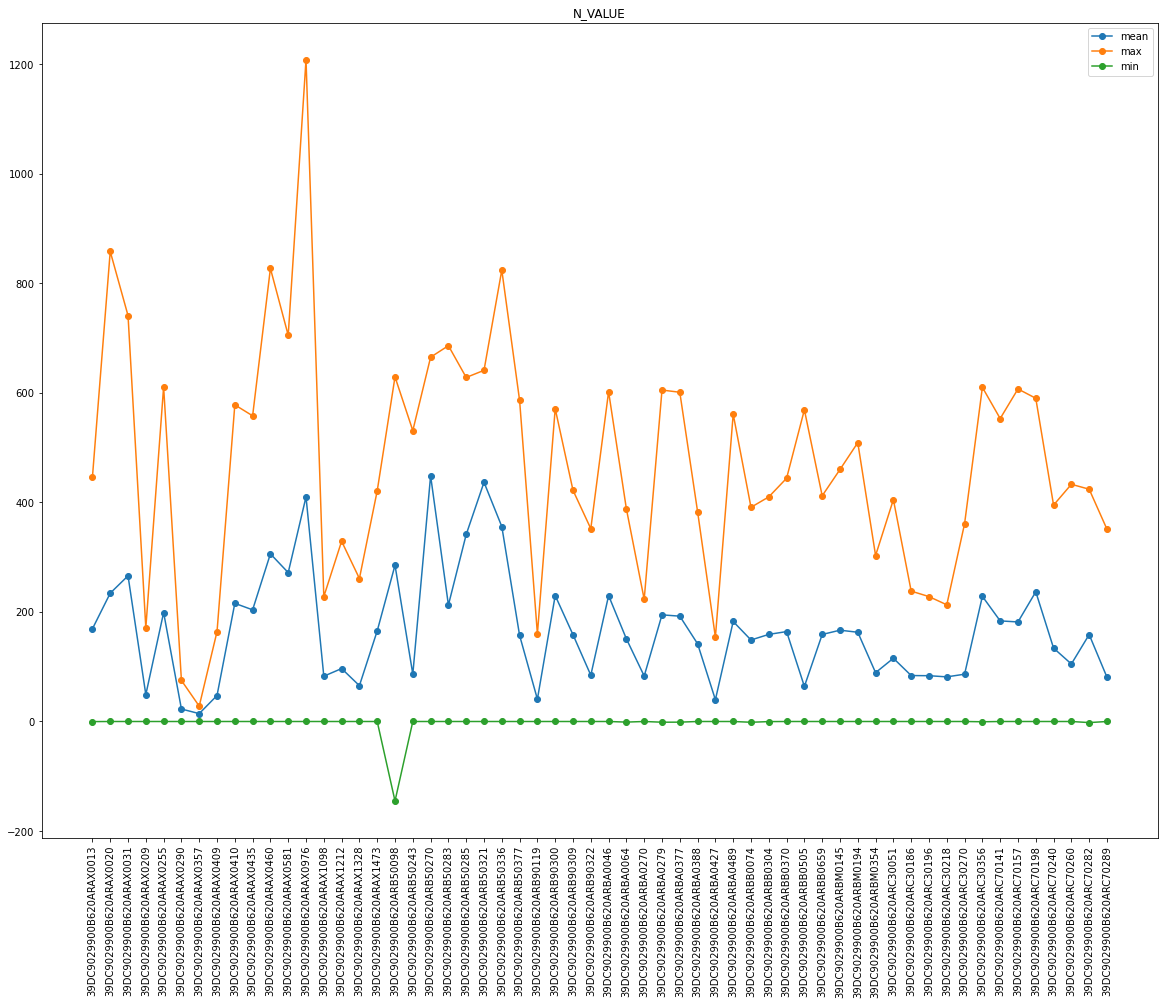

In [24]:
# N

fig = plt.figure(figsize=(20,15)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 색상 설정
ax = fig.add_subplot() ## 그림 뼈대(프레임) 생성
 
ax.plot(x2, y2, marker='o',label='mean') ## 선그래프 생성
ax.plot(x4, y4, marker='o',label='max') 
ax.plot(x6, y6, marker='o',label='min') 

ax.legend()
plt.title('N_VALUE')
plt.xticks(rotation = 90)
plt.show()

In [13]:
sqci2

,INSP_DTL_SEQ,INSP_DTL_CODE,VALUE,PROD_SN,START_TIME,END_TIME,PASS_YN,DURATION_TIME
0,0,1,0.000,39DC9029900B620ARAN0001,20211022115325,20211022115430,1,105
1,1,1,0.000,39DC9029900B620ARAN0001,20211022115325,20211022115430,1,105
2,2,1,7.000,39DC9029900B620ARAN0001,20211022115325,20211022115430,1,105
3,3,1,36.000,39DC9029900B620ARAN0001,20211022115325,20211022115430,1,105
4,4,1,36.000,39DC9029900B620ARAN0001,20211022115325,20211022115430,1,105
...,...,...,...,...,...,...,...,...
700379,61,2,5.000,39DC9029900B620ARC70312,20211207094658,20211207094803,1,145
700380,62,2,4.900,39DC9029900B620ARC70312,20211207094658,20211207094803,1,145
700381,63,2,5.000,39DC9029900B620ARC70312,20211207094658,20211207094803,1,145
700382,64,2,5.100,39DC9029900B620ARC70312,20211207094658,20211207094803,1,145


## $ mean  \pm  std $ -> 예측

In [5]:
sqci_ad01 = sqci2[(sqci2['INSP_DTL_CODE'] == 1) & (sqci2['PASS_YN'] == 1)]
#sqci_ad02 = sqci2[sqci2['INSP_DTL_CODE'] == 2]

# AD01
sqci_ad01_mean = sqci_ad01.groupby(['PROD_SN', 'PASS_YN']).mean() # sn당 value의 최댓값
sqci_ad01_mean.reset_index(inplace = True)
sqci_ad01_mean = sqci_ad01_mean[['PROD_SN', 'PASS_YN', 'VALUE', 'DURATION_TIME']]

sqci_ad01_max = sqci_ad01.groupby(['PROD_SN', 'PASS_YN']).max() # sn당 value의 최댓값
sqci_ad01_max.reset_index(inplace = True)
sqci_ad01_max = sqci_ad01_max[['PROD_SN', 'PASS_YN', 'VALUE', 'DURATION_TIME']]

sqci_ad01_min = sqci_ad01.groupby(['PROD_SN', 'PASS_YN']).min() # sn당 value의 최솟값
sqci_ad01_min.reset_index(inplace = True)
sqci_ad01_min = sqci_ad01_min[['PROD_SN', 'PASS_YN', 'VALUE', 'DURATION_TIME']]

print(sqci_ad01_max['VALUE'].std())
print(sqci_ad01_mean['VALUE'].std())

#  AD02
#sqci_ad02_mean = sqci_ad02.groupby(['PROD_SN', 'PASS_YN']).mean() # sn당 value의 최댓값
#sqci_ad02_mean.reset_index(inplace = True)
#sqci_ad02_mean = sqci_ad02_mean[['PROD_SN', 'PASS_YN', 'VALUE', 'DURATION_TIME']]

41.42846183833411
20.357155870176


### accuracy

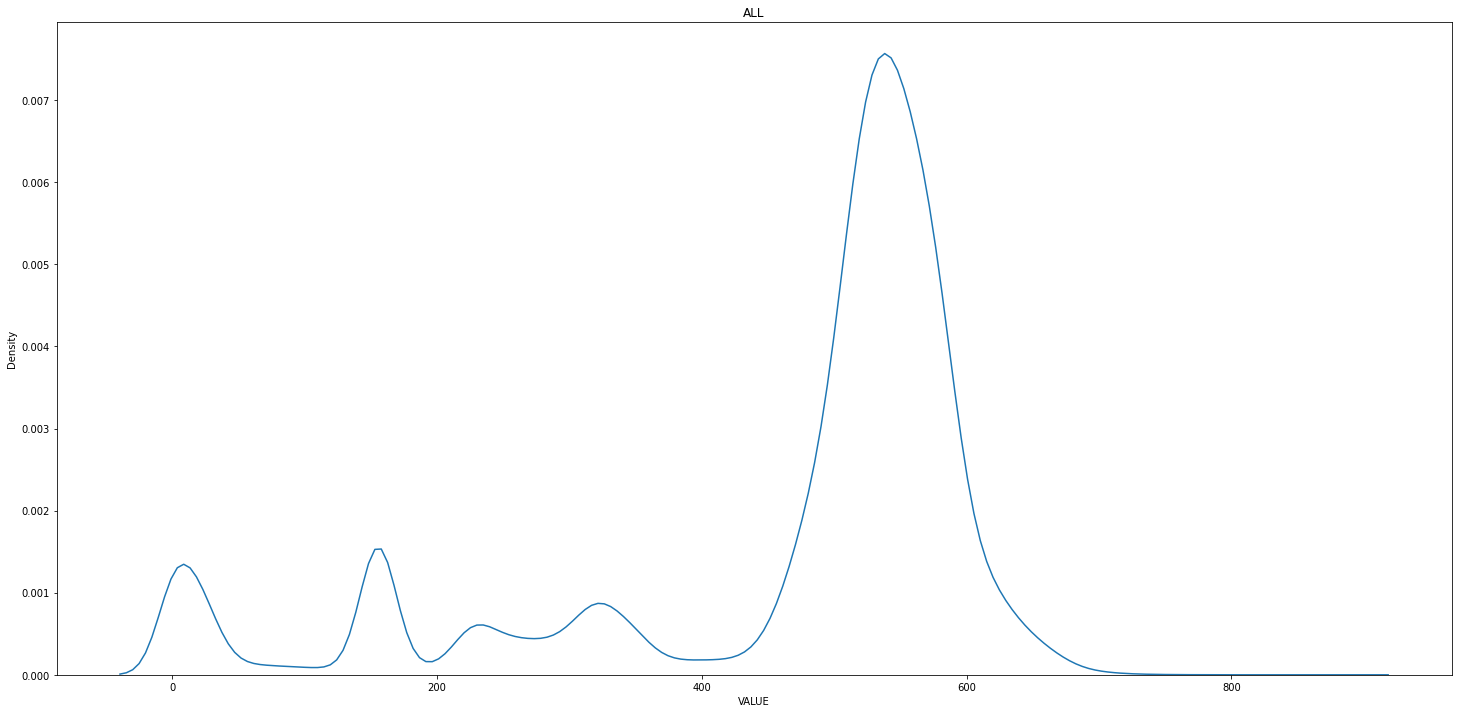

In [58]:
# 1. 분포 확인
sns.distplot(sqci_ad01['VALUE'], bins = list_, hist=False, )

plt.title('ALL')
plt.show()

In [6]:
len(sqci_ad01)

345913

In [155]:
sqci_ad01

,INSP_DTL_SEQ,INSP_DTL_CODE,VALUE,PROD_SN,START_TIME,END_TIME,PASS_YN,DURATION_TIME
0,0,1,0.000,39DC9029900B620ARAN0001,20211022115325,20211022115430,1,105
1,1,1,0.000,39DC9029900B620ARAN0001,20211022115325,20211022115430,1,105
2,2,1,7.000,39DC9029900B620ARAN0001,20211022115325,20211022115430,1,105
3,3,1,36.000,39DC9029900B620ARAN0001,20211022115325,20211022115430,1,105
4,4,1,36.000,39DC9029900B620ARAN0001,20211022115325,20211022115430,1,105
...,...,...,...,...,...,...,...,...
345908,61,1,577.000,39DC9029900B620ARC70312,20211207094658,20211207094803,1,145
345909,62,1,164.000,39DC9029900B620ARC70312,20211207094658,20211207094803,1,145
345910,63,1,162.000,39DC9029900B620ARC70312,20211207094658,20211207094803,1,145
345911,64,1,162.000,39DC9029900B620ARC70312,20211207094658,20211207094803,1,145


In [180]:
sqci_ad01_all.drop(['YN'], axis = 1, inplace = True)

In [7]:
# 2-1 - 전체 

# reset index
sqci_ad01_all = sqci_ad01.reset_index(drop = True)

# 전체의 mean, std
sqci_mean = sqci_ad01_all['VALUE'].mean()
sqci_std = sqci_ad01_all['VALUE'].std()
print(sqci_mean)
print(sqci_std)

# yn mapping
#for i in range(0, len(sqci_ad01_all)):
#    if (sqci_ad01_all['VALUE'][i] < sqci_mean + sqci_std) & (sqci_ad01_all['VALUE'][i] > sqci_mean - sqci_std) :
#        sqci_ad01_all['YN'][i] = 1
#    else :
#        sqci_ad01_all['YN'][i] = 0

sqci_ad01_all['failure']=0
sqci_ad01_all['failure']=np.where((sqci_ad01_all['VALUE']>=(sqci_mean+sqci_std)) | (sqci_ad01_all['VALUE']<=(sqci_mean-sqci_std)),'N','Y')

460.18155432146233
168.56737963145912


In [8]:
sqci_ad01_all.count()

INSP_DTL_SEQ     345913
INSP_DTL_CODE    345913
VALUE            345913
PROD_SN          345913
START_TIME       345913
END_TIME         345913
PASS_YN          345913
DURATION_TIME    345913
failure          345913
dtype: int64

In [10]:
sqci_ad01_all[sqci_ad01_all['failure'] == 'N']
# y : 278856
# n : 67057
print(278856 / 345913)

0.8061448977054925


In [15]:
# 2-2. 봉오리 4개 발견 - 0~100, 100~190, 190~400, 400~max
sqci_ad01_1 = sqci_ad01[sqci_ad01['VALUE'] < 100]
sqci_ad01_2 = sqci_ad01[(sqci_ad01['VALUE'] >= 100) & (sqci_ad01['VALUE'] < 190)]
sqci_ad01_3 = sqci_ad01[(sqci_ad01['VALUE'] >= 190) & (sqci_ad01['VALUE'] < 400)]
sqci_ad01_4 = sqci_ad01[(sqci_ad01['VALUE'] >= 400) & (sqci_ad01['VALUE'] < 750)]

# reset index
for i in range(1, 5):
    globals()['sqci_ad01_{}'.format(i)].reset_index(drop = True)

    
# 각 봉오리 별 mean, std
for i in range(1,5):
    globals()['sqci_mean{}'.format(i)] = globals()['sqci_ad01_{}'.format(i)]['VALUE'].mean()
    globals()['sqci_std{}'.format(i)] = globals()['sqci_ad01_{}'.format(i)]['VALUE'].std()

    print('{}번째 mean : '.format(i),  globals()['sqci_mean{}'.format(i)])
    print('{}번째 std : '.format(i),  globals()['sqci_std{}'.format(i)])
    print('---------------------------------')

# yn mapping
#for j in range(1,5):
#    for i in range(len(globals()['sqci_ad01_{}'.format(j)])):
#        if (globals()['sqci_ad01_{}'.format(j)]['VALUE'][i] < sqci_mean + sqci_std) & (globals()['sqci_ad01_{}'.format(j)]['VALUE'][i] > sqci_mean - sqci_std) :
#            globals()['sqci_ad01_{}'.format(j)]['YN'][i] = 1
#        else :
#            globals()['sqci_ad01_{}'.format(j)]['YN'][i] = 0
#for i in range(1, 5):
#    globals()['sqci_ad01_{}'.format(i)]['failure'] = 0
#    globals()['sqci_ad01_{}'.format(i)]['failure'] = np.where((globals()['sqci_ad01_{}'.format(i)]['VALUE'] >= (sqci_mean + sqci_std)) | (globals()['sqci_ad01_{}'.format(i)]['VALUE'] <= (sqci_mean - sqci_std)))

    
sqci_ad01_1['failure'] = 0
sqci_ad01_1['failure']=np.where((sqci_ad01_1['VALUE']>=(sqci_mean1+sqci_std1)) | (sqci_ad01_1['VALUE']<=(sqci_mean1-sqci_std1)),'N','Y')

sqci_ad01_2['failure'] = 0
sqci_ad01_2['failure']=np.where((sqci_ad01_2['VALUE']>=(sqci_mean2+sqci_std2)) | (sqci_ad01_2['VALUE']<=(sqci_mean2-sqci_std2)),'N','Y')

sqci_ad01_3['failure'] = 0
sqci_ad01_3['failure']=np.where((sqci_ad01_3['VALUE']>=(sqci_mean3+sqci_std3)) | (sqci_ad01_3['VALUE']<=(sqci_mean3-sqci_std3)),'N','Y')

sqci_ad01_4['failure'] = 0
sqci_ad01_4['failure']=np.where((sqci_ad01_4['VALUE']>=(sqci_mean4+sqci_std4)) | (sqci_ad01_4['VALUE']<=(sqci_mean4-sqci_std4)),'N','Y')

1번째 mean :  16.97204328781242
1번째 std :  20.938170684977294
---------------------------------
2번째 mean :  154.30232325255358
2번째 std :  10.618527234743288
---------------------------------
3번째 mean :  294.8520807816105
3번째 std :  49.35250056147479
---------------------------------
4번째 mean :  543.2678092176578
4번째 std :  42.35743185246879
---------------------------------


In [17]:
print(sqci_ad01_1[sqci_ad01_1['failure'] == 'Y']['failure'].count())
print(sqci_ad01_1[sqci_ad01_1['failure'] == 'N']['failure'].count())
# 불량율
print(20601/23286)
print('-----------------------')

# y : 20601
# n : 2685

print(sqci_ad01_2[sqci_ad01_2['failure'] == 'Y']['failure'].count())
print(sqci_ad01_2[sqci_ad01_2['failure'] == 'N']['failure'].count())
# 불량율
print(17843/19973)
print('-----------------------')
# y : 17843
# n : 2130

print(sqci_ad01_3[sqci_ad01_3['failure'] == 'Y']['failure'].count())
print(sqci_ad01_3[sqci_ad01_3['failure'] == 'N']['failure'].count())
# 불량율
print(21257/35107)
print('-----------------------')
# y : 21257
# n : 13850

print(sqci_ad01_4[sqci_ad01_4['failure'] == 'Y']['failure'].count())
print(sqci_ad01_4[sqci_ad01_4['failure'] == 'N']['failure'].count())
# 불량율
print(195134/267530)
print('-----------------------')
# y : 195134
# n : 72396

20601
2685
0.8846946663231126
-----------------------
17842
2130
0.8933560306413658
-----------------------
21257
13850
0.605491782265645
-----------------------
195134
72396
0.7293910963256457
-----------------------


In [157]:
len(sqci_ad01_a)

78365

In [161]:
if (sqci_ad01_a['VALUE'][0] < sqci_mean + sqci_std) & (sqci_ad01_a['VALUE'][0] > sqci_mean - sqci_std):
    sqci_ad01_a['YN'][0] = 1
else :
    sqci_ad01_a['YN'][0] = 0

In [172]:
if (sqci_ad01_a['VALUE'][1] < sqci_mean) & (sqci_ad01_a['VALUE'][0] > sqci_mean - sqci_std):
    sqci_ad01_a['YN'][1] = 13
else :
    sqci_ad01_a['YN'][1] = 12

In [194]:
# 2-3. 2개로 구분 - 400을 기준으로
sqci_ad01_a = sqci_ad01[sqci_ad01['VALUE'] < 400]
sqci_ad01_b = sqci_ad01[sqci_ad01['VALUE'] > 400]

# reset index
sqci_ad01_a = sqci_ad01_a.reset_index(drop = True)
sqci_ad01_b = sqci_ad01_b.reset_index(drop = True)

# 각 구간 별 mean, std
sqci_mean_a = sqci_ad01_a['VALUE'].mean()
sqci_std_a = sqci_ad01_a['VALUE'].std()
sqci_mean_b = sqci_ad01_b['VALUE'].mean()
sqci_std_b = sqci_ad01_b['VALUE'].std()

# yn mapping
#for i in range(len(sqci_ad01_a)):
#    if (sqci_ad01_a['VALUE'][i] < sqci_mean + sqci_std) & (sqci_ad01_a['VALUE'][i] > sqci_mean - sqci_std):
#        sqci_ad01_a['YN'][i] = 1
#    else :
#        sqci_ad01_a['YN'][i] = 0
        
#for i in range(len(sqci_ad01_b)):
#    if (sqci_ad01_b['VALUE'][i] < sqci_mean + sqci_std) & (sqci_ad01_b['VALUE'][i] > sqci_mean - sqci_std):
#        sqci_ad01_b['YN'][i] = 1
#    else :
#        sqci_ad01_b['YN'][i] = 0

sqci_ad01_a['failure'] = 0
sqci_ad01_a['failure']=np.where((sqci_ad01_a['VALUE']>=(sqci_mean+sqci_std)) | (sqci_ad01_a['VALUE']<=(sqci_mean-sqci_std)),'N','Y')
print(sqci_ad01_a[sqci_ad01_a['failure'] == 'Y']['failure'].count())
print(sqci_ad01_a[sqci_ad01_a['failure'] == 'N']['failure'].count())
print('-----------------------')
# y : 19993
# n : 58372

sqci_ad01_b['failure'] = 0
sqci_ad01_b['failure']=np.where((sqci_ad01_b['VALUE']>=(sqci_mean+sqci_std)) | (sqci_ad01_b['VALUE']<=(sqci_mean-sqci_std)),'N','Y')
print(sqci_ad01_b[sqci_ad01_b['failure'] == 'Y']['failure'].count())
print(sqci_ad01_b[sqci_ad01_b['failure'] == 'N']['failure'].count())
print('-----------------------')
# y : 258802
# n : 8685

19993
58372
-----------------------
258802
8685
-----------------------


In [178]:
sqci_ad01_all[sqci_ad01_all['failure'] == 'Y']

,INSP_DTL_SEQ,INSP_DTL_CODE,VALUE,PROD_SN,START_TIME,END_TIME,PASS_YN,DURATION_TIME,YN,failure
5,5,1,344.000,39DC9029900B620ARAN0001,20211022115325,20211022115430,1,105,0,Y
6,6,1,328.000,39DC9029900B620ARAN0001,20211022115325,20211022115430,1,105,0,Y
7,7,1,328.000,39DC9029900B620ARAN0001,20211022115325,20211022115430,1,105,0,Y
10,10,1,321.000,39DC9029900B620ARAN0001,20211022115325,20211022115430,1,105,0,Y
11,11,1,505.000,39DC9029900B620ARAN0001,20211022115325,20211022115430,1,105,0,Y
...,...,...,...,...,...,...,...,...,...,...
345904,57,1,550.000,39DC9029900B620ARC70312,20211207094658,20211207094803,1,145,0,Y
345905,58,1,567.000,39DC9029900B620ARC70312,20211207094658,20211207094803,1,145,0,Y
345906,59,1,586.000,39DC9029900B620ARC70312,20211207094658,20211207094803,1,145,0,Y
345907,60,1,591.000,39DC9029900B620ARC70312,20211207094658,20211207094803,1,145,0,Y
